In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize

import pickle

import importlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# import customized packages
from Packages.Math import DataPairMath
from Packages.ROIOps import ROIPairOps

from Packages.OTAnalysis import (
    ComplexResponse,
    DoubleGaussian,
    EvaResponseFit,
    FitResponse,
    OSIndex,
)

In [3]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\JEDi2P_OS_DoubleGuassianFit_Ver01.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [4]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):

    assert len(spike_event.shape) == 2
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    # spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    # spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            # spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s           
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(float) / duration_s

    return spike_rate

def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces

def calculate_trace_mean_in_time_stamp(src_traces, stim_tstamp):
    assert len(src_traces.shape) == 2
    
    nof_traces = src_traces.shape[0]
    trace_len = src_traces.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    trace_means = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            cur_trace_mean = np.mean(src_traces[:, tstamp_start:tstamp_end], axis = -1)
            trace_means[i_orint, i_step, :] = cur_trace_mean
            
    return trace_means
    
SAVE_PROGRESS(HISTORY_FILEPATH) 

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\JEDi2P_OS_DoubleGuassianFit_Ver01_2024-03-07.py


In [5]:
def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces

def calculate_trace_mean_in_time_stamp(src_traces, stim_tstamp):
    assert len(src_traces.shape) == 2
    
    nof_traces = src_traces.shape[0]
    trace_len = src_traces.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    trace_means = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            cur_trace_mean = np.mean(src_traces[:, tstamp_start:tstamp_end], axis = -1)
            trace_means[i_orint, i_step, :] = cur_trace_mean
            
    return trace_means
    
SAVE_PROGRESS(HISTORY_FILEPATH) 

Time since last sync = 12.38 s


In [6]:
# basic plot functions
def raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)

def stim_time_stamp_axvline(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvline(tstamp_start, color = facecolor_strs[i_step])
            plt.axvline(tstamp_end, color = facecolor_strs[i_step])
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 13.86 s


In [7]:
# display configuration

my_monitor_dpi_px = 96
letter_paper_size_inch = np.array((8.5, 11))

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 15.92 s


In [8]:
# source configuration
src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\stats_analysis_data.hdf5"


dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "figures"


SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 17.46 s


In [9]:
# load source data 

nof_rois = None
nof_trials = None
nof_frames = None
nof_orient = None

stim_tstamp_s = None
stim_tstamp = None
epsp_tstamp = None

orient_angles_deg = None
orient_angles_rad = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_diff_responses = None
roi_glob_diff_responses = None
roi_epsp_subthd_responses = None
roi_epsp_session_subthd_responses = None
roi_glob_diff_gOSIs = None
roi_epsp_session_subthd_gOSIs = None

roi_fft_responses = None
roi_fft_subthd_responses = None

roi_mob_subthd_responses = None
roi_mean_max_subthd_responses = None

snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None

with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]
    epsp_tstamp = hdf5_file["epsp_tstamp"][()]

    orient_angles_deg = hdf5_file["orient_angles_deg"][()]
    orient_angles_rad = hdf5_file["orient_angles_rad"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    roi_diff_responses =  np.zeros((nof_rois, nof_orients))
    roi_glob_diff_responses = np.zeros((nof_rois, nof_orients))
    roi_epsp_subthd_responses = np.zeros((nof_rois, nof_orients))
    roi_epsp_session_subthd_responses = np.zeros((nof_rois, nof_orients))
    roi_glob_diff_gOSIs = np.zeros((nof_rois,))
    roi_epsp_session_subthd_gOSIs = np.zeros((nof_rois,))
    roi_fft_responses = np.zeros((nof_rois, nof_orients))
    roi_fft_subthd_responses = np.zeros((nof_rois, nof_orients))
    roi_mob_subthd_responses = np.zeros((nof_rois, nof_orients))
    roi_mean_max_subthd_responses = np.zeros((nof_rois, nof_orients))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_diff_responses[i_roi,:] = hdf5_file[os.path.join(cur_roi_str, "diff_responses")][()]
        roi_glob_diff_responses[i_roi,:] = hdf5_file[os.path.join(cur_roi_str, "glob_diff_responses")][()]
        roi_epsp_subthd_responses[i_roi,:] = hdf5_file[os.path.join(cur_roi_str, "epsp_subthd_responses")][()]
        roi_epsp_session_subthd_responses[i_roi,:] = hdf5_file[os.path.join(cur_roi_str, "epsp_session_subthd_responses")][()]
        roi_glob_diff_gOSIs[i_roi] = hdf5_file[os.path.join(cur_roi_str, "glob_diff_gOSI")][()]
        roi_epsp_session_subthd_gOSIs[i_roi] = hdf5_file[os.path.join(cur_roi_str, "epsp_session_subthd_gOSI")][()]
        roi_fft_responses[i_roi] = hdf5_file[os.path.join(cur_roi_str, "fft_responses")][()]
        roi_fft_subthd_responses[i_roi, :] = hdf5_file[os.path.join(cur_roi_str, "fft_subthd_responses")][()]
        roi_mob_subthd_responses[i_roi, :] = hdf5_file[os.path.join(cur_roi_str, "mob_subthd_responses")][()]
        roi_mean_max_subthd_responses[i_roi, :] = hdf5_file[os.path.join(cur_roi_str, "mean_max_subthd_responses")][()]


SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 26.95 s


In [10]:
# print statistics test result

print(t_test_pass_mask.size)
print(np.sum(t_test_pass_mask))
print(np.sum(diff_t_test_pass_mask))
print(np.sum(np.logical_and(t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, anova_test_pass_mask)))
print(np.sum(np.logical_and(t_test_pass_mask, diff_anova_test_pass_mask)))
print(np.sum(np.logical_and(diff_t_test_pass_mask, diff_anova_test_pass_mask)))

SAVE_PROGRESS(HISTORY_FILEPATH)

202
77
100
63
76
24
26
Time since last sync = 26.97 s


In [11]:
# get roi idxs pass tests 

select_mask = np.full(t_test_pass_mask.shape, True)
select_mask = np.logical_and(select_mask, diff_t_test_pass_mask)
select_mask = np.logical_and(select_mask, anova_test_pass_mask)

select_roi_idxs = np.where(select_mask)[0]
select_roi_idxs = np.array(select_roi_idxs)

print(select_roi_idxs)

SAVE_PROGRESS(HISTORY_FILEPATH)

[  3  11  16  17  23  25  26  31  33  39  40  41  43  45  51  53  55  57
  58  62  64  65  71  72  74  75  76  77  80  82  84  87  90  91  92  93
  95  97 105 106 107 108 109 111 113 116 123 125 126 127 129 131 136 138
 139 141 143 144 145 146 148 154 155 161 163 171 177 181 182 184 185 192
 193 198 199 201]
Time since last sync = 33.44 s


In [12]:
# gaussian fitting support function 
def est_double_gauss_fit_init_guess(orint_angle_rad, reponses):
    nof_responses = len(reponses)
    max_response_idx = np.argmax(reponses)
    oppo_response_idx = nof_responses - 1 - max_response_idx
    if max_response_idx > nof_responses//2:
        tmp = max_response_idx
        max_response_idx = oppo_response_idx
        oppo_response_idx = max_response_idx
    init_guess = [0,
                  max(reponses[max_response_idx], 0),
                  max(reponses[oppo_response_idx], 0),
                  orint_angle_rad[max_response_idx],
                  np.pi/(nof_responses*2)]
    return init_guess

def est_double_gauss_fit_bounds(orint_angle_rad, reponses):
    max_response_ratio = 1
    bounds = (
        [np.min(reponses), 
         0, 
         0, 
         0, 
         0],
        [np.max(reponses), 
         max_response_ratio*(np.max(reponses) - np.min(reponses)), 
         max_response_ratio*(np.max(reponses) - np.min(reponses)), 
         np.pi, 
         np.pi/2]
    )
    return bounds

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 45.04 s


fr eva E = 0.26152088845262306
fr eva Rsqure = 0.7518625951528626
subthd eva E = 9.47499814987843e-05
subthd eva Rsqure = 0.5627711343244532


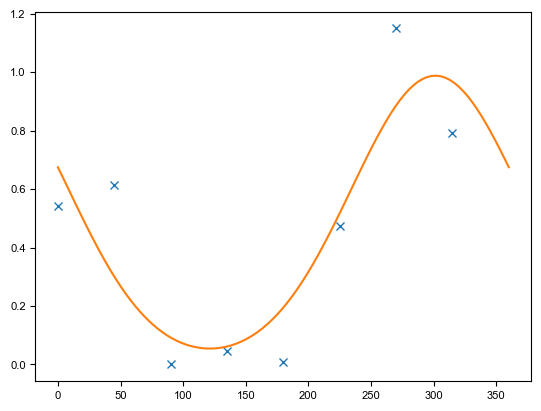

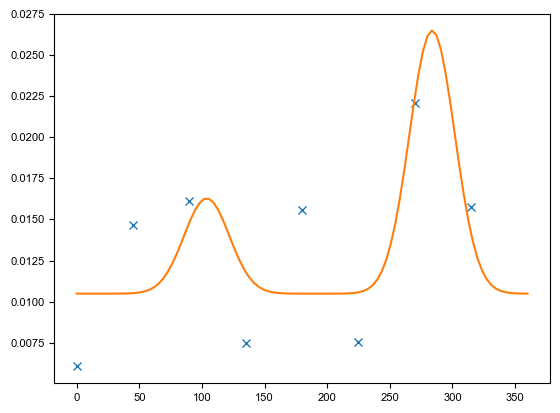

Time since last sync = 46.77 s


In [13]:
# check double gaussian fit on one cell
# %load_ext autoreload
# %autoreload 2
importlib.reload(FitResponse)
importlib.reload(DoubleGaussian)
importlib.reload(EvaResponseFit)


check_roi_idx = 182

check_roi_fr_responses = roi_glob_diff_responses[check_roi_idx, :]
# check_roi_fr_responses = roi_diff_responses[check_roi_idx, :]
# check_roi_subthd_responses = roi_epsp_session_subthd_responses[check_roi_idx, :]

# check_roi_fr_responses = roi_fft_responses[check_roi_idx, :]
# check_roi_subthd_responses = roi_fft_subthd_responses[check_roi_idx, :]
check_roi_subthd_responses = roi_mob_subthd_responses[check_roi_idx, :]
# check_roi_subthd_responses = roi_mean_max_subthd_responses[check_roi_idx, :]

check_orint_angle_rad = orient_angles_rad
check_orint_angle_deg = orient_angles_deg

fr_init_guess = est_double_gauss_fit_init_guess(check_orint_angle_rad, check_roi_fr_responses)
fr_bounds = est_double_gauss_fit_bounds(check_orint_angle_rad, check_roi_fr_responses)

fr_double_gaussian_fit_obj = FitResponse.DoubleGaussian()
fr_double_gaussian_fit_obj.fit(check_orint_angle_rad, 
                               check_roi_fr_responses,
                               # init_guess = fr_init_guess,
                               bounds = fr_bounds)

subthd_init_guess = est_double_gauss_fit_init_guess(check_orint_angle_rad, check_roi_subthd_responses)
subthd_bounds = est_double_gauss_fit_bounds(check_orint_angle_rad, check_roi_subthd_responses)

subthd_double_gaussian_fit_obj = FitResponse.DoubleGaussian()
subthd_double_gaussian_fit_obj.fit(check_orint_angle_rad, 
                                   check_roi_subthd_responses,
                                   # init_guess = subthd_init_guess,
                                   bounds = subthd_bounds)

check_fr_fitted_response = fr_double_gaussian_fit_obj.apply(check_orint_angle_rad)
check_fr_eva_E = EvaResponseFit.eva_response_fit_E(check_roi_fr_responses, check_fr_fitted_response)
check_fr_eva_Rsquare = EvaResponseFit.eva_response_fit_Rsquare(check_roi_fr_responses, check_fr_fitted_response)

check_subthd_fitted_response = subthd_double_gaussian_fit_obj.apply(check_orint_angle_rad)
check_subthd_eva_E = EvaResponseFit.eva_response_fit_E(check_roi_subthd_responses, check_subthd_fitted_response)
# check_subthd_eva_Rsquare = EvaResponseFit.eva_response_fit_Rsquare(check_roi_subthd_responses, check_subthd_fitted_response)
check_subthd_eva_Rsquare = EvaResponseFit.eva_response_fit_wiki_Rsquare(check_roi_subthd_responses, check_subthd_fitted_response)


print(f"fr eva E = {check_fr_eva_E}")
print(f"fr eva Rsqure = {check_fr_eva_Rsquare}")

print(f"subthd eva E = {check_subthd_eva_E}")
print(f"subthd eva Rsqure = {check_subthd_eva_Rsquare}")

plt.figure()
plt.plot(check_orint_angle_deg, check_roi_fr_responses, "x")
plot_xs = np.linspace(0, 2*np.pi , 100)
plt.plot(plot_xs * (180/np.pi), fr_double_gaussian_fit_obj.apply(plot_xs))
plt.show()

plt.figure()
plt.plot(check_orint_angle_deg, check_roi_subthd_responses, "x")
plot_xs = np.linspace(0, 2*np.pi , 100)
plt.plot(plot_xs * (180/np.pi), subthd_double_gaussian_fit_obj.apply(plot_xs))
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [14]:
# double gaussian fit for all os cells


os_roi_idxs = select_roi_idxs
# os_responses = [roi_glob_diff_responses, roi_epsp_session_subthd_responses]
# os_responses = [roi_fft_responses, roi_fft_subthd_responses]
# os_responses = [roi_glob_diff_responses, roi_fft_subthd_responses]
# os_responses = [roi_glob_diff_responses, roi_mob_subthd_responses]
os_responses = [roi_glob_diff_responses, roi_mean_max_subthd_responses]
# os_responses = [roi_diff_responses, roi_mean_max_subthd_responses]



os_orint_angle_rads = [orient_angles_rad for _ in range(len(os_responses))]
                
double_gauss_params_len = 5
nof_responses = len(os_responses)
nof_rois = len(os_roi_idxs)

os_double_gauss_params = np.zeros((nof_rois, nof_responses, double_gauss_params_len))
os_double_gauss_eva_Es = np.zeros((nof_rois, nof_responses))
os_double_gauss_eva_Rsquare = np.zeros((nof_rois, nof_responses))

for i_roi in range(nof_rois):
    cur_roi_idx = os_roi_idxs[i_roi]
    for i_response in range(nof_responses):
        cur_orint_angle_rad = os_orint_angle_rads[i_response]
        cur_responses = os_responses[i_response][cur_roi_idx, :]
        cur_init_guess = est_double_gauss_fit_init_guess(cur_orint_angle_rad, 
                                                         cur_responses)
        cur_bounds = est_double_gauss_fit_bounds(cur_orint_angle_rad, 
                                                 cur_responses)
        cur_double_gaussian_fit_obj = FitResponse.DoubleGaussian()
        cur_double_gaussian_fit_obj.fit(cur_orint_angle_rad, 
                                        cur_responses,
                                         # init_guess = cur_init_guess,
                                        bounds = cur_bounds)
        os_double_gauss_params[i_roi, i_response, :] = cur_double_gaussian_fit_obj.params

        # cur_fitted_response = cur_double_gaussian_fit_obj.apply(check_orint_angle_rad)
        cur_fitted_response = cur_double_gaussian_fit_obj.apply(cur_orint_angle_rad)
        cur_subthd_eva_E = EvaResponseFit.eva_response_fit_E(cur_responses, cur_fitted_response)
        cur_subthd_eva_Rsquare = EvaResponseFit.eva_response_fit_wiki_Rsquare(cur_responses, cur_fitted_response)

        os_double_gauss_eva_Es[i_roi, i_response] = cur_subthd_eva_E
        os_double_gauss_eva_Rsquare[i_roi, i_response] = cur_subthd_eva_Rsquare
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 52.20 s


In [17]:
# calculate OSI
nof_responses = len(os_responses)
nof_rois = len(os_roi_idxs)

os_double_guass_fit_OSI = np.zeros((nof_rois, nof_responses))
os_double_gauss_theta_prefs = np.zeros((nof_rois, nof_responses))
os_double_gauss_R_prefs = np.zeros((nof_rois, nof_responses))

for i_roi in range(nof_rois):
    for i_response in range(nof_responses):
        cur_gauss_params = os_double_gauss_params[i_roi, i_response, :]
        
        cur_A_pref = cur_gauss_params[1] 
        cur_A_oppo = cur_gauss_params[2]
        cur_theta_pref = cur_gauss_params[3]
        cur_theta_oppo = cur_theta_pref + np.pi
        if cur_A_oppo > cur_A_pref:
            cur_tmp = cur_theta_oppo
            cur_theta_oppo = cur_theta_pref
            cur_theta_pref = cur_tmp
        
        cur_theta_ortho = np.mod(cur_theta_pref, np.pi) + np.pi/2

        double_gaussian_fit_obj = FitResponse.DoubleGaussian(cur_gauss_params)

        cur_R_ortho = double_gaussian_fit_obj.apply(cur_theta_ortho)
        cur_R_pref = double_gaussian_fit_obj.apply(cur_theta_pref)
        cur_R_oppo = double_gaussian_fit_obj.apply(cur_theta_oppo)
    
        assert(cur_R_pref >= cur_R_oppo)

        cur_OSI = (cur_R_pref - cur_R_ortho)/(cur_R_pref + cur_R_ortho)
        cur_DSI = (cur_R_pref - cur_R_oppo)/(cur_R_pref + cur_R_oppo)

        os_double_guass_fit_OSI[i_roi, i_response] = cur_OSI
        os_double_gauss_theta_prefs[i_roi, i_response] = cur_theta_pref
        os_double_gauss_R_prefs[i_roi, i_response] = cur_R_pref

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\JEDi2P_OS_DoubleGuassianFit_Ver01_2024-03-07.py


(76, 2)
(76, 2)


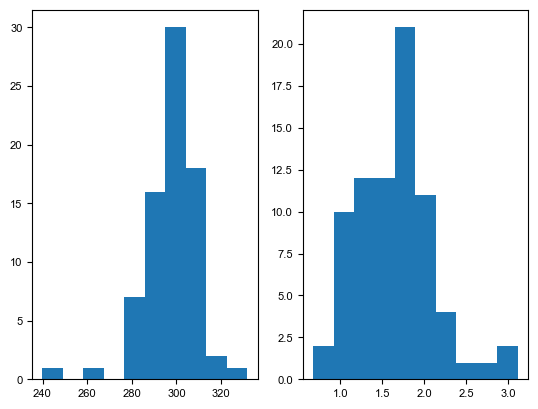

In [20]:
print(os_double_gauss_theta_prefs.shape)
print(os_double_gauss_R_prefs.shape)

plt.figure()
plt.subplot(1,2,1)
plt.hist(os_double_gauss_theta_prefs[:,0] * 180/np.pi)
plt.subplot(1,2,2)
plt.hist(os_double_gauss_R_prefs[:,0])
plt.show()

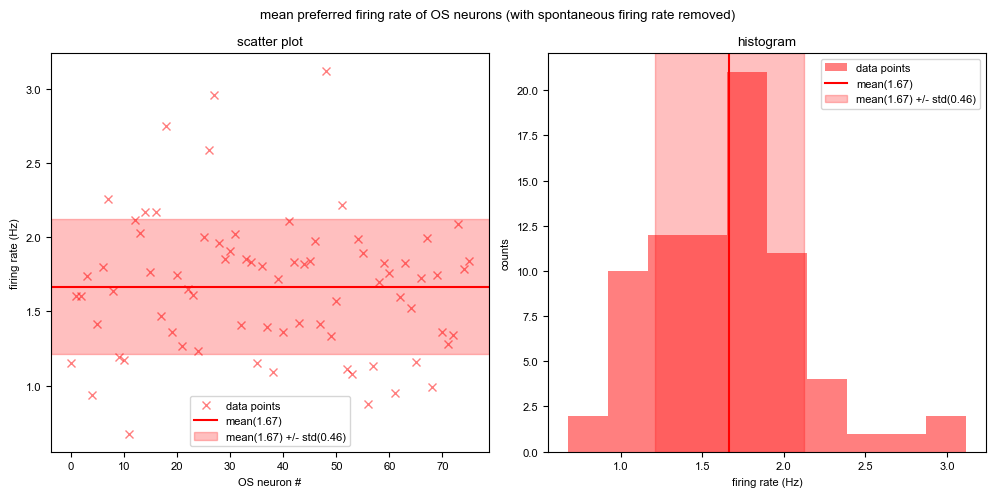

In [40]:
plot_data = os_double_gauss_R_prefs[:,0]
plot_mean = np.mean(plot_data)
plot_std = np.std(plot_data)

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(plot_data, 
         "rx", alpha = 0.5,
         label = "data points")
plt.axhline(plot_mean, 
            color = "r",
            label = f"mean({plot_mean:0.2f})")
plt.axhspan(plot_mean - plot_std, plot_mean + plot_std, 
            color = "r", alpha = 0.25,
            label = f"mean({plot_mean:0.2f}) +/- std({plot_std:0.2f})")
plt.legend()
plt.xlabel("OS neuron #")
plt.ylabel("firing rate (Hz)")
plt.title("scatter plot")
plt.subplot(1,2,2)
plt.hist(plot_data, bins = 10,
         color = "r", alpha = 0.5,
         label = "data points")
plt.axvline(plot_mean, 
            color = "r",
            label = f"mean({plot_mean:0.2f})")
plt.axvspan(plot_mean - plot_std, plot_mean + plot_std, 
            color = "r", alpha = 0.25,
            label = f"mean({plot_mean:0.2f}) +/- std({plot_std:0.2f})")
plt.legend()
plt.xlabel("firing rate (Hz)")
plt.ylabel("counts")
plt.title("histogram")
plt.suptitle("mean preferred firing rate of OS neurons (with spontaneous firing rate removed)")
plt.tight_layout()
plt.show()

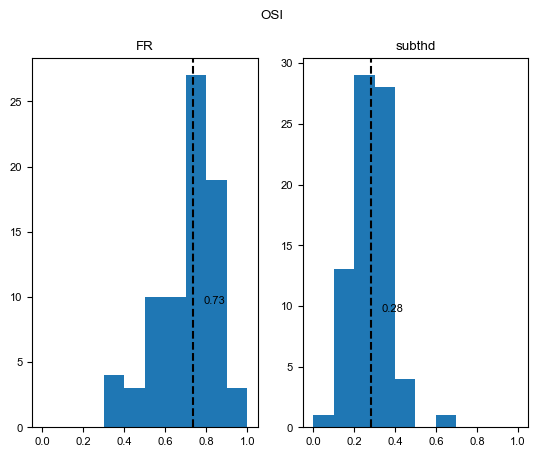

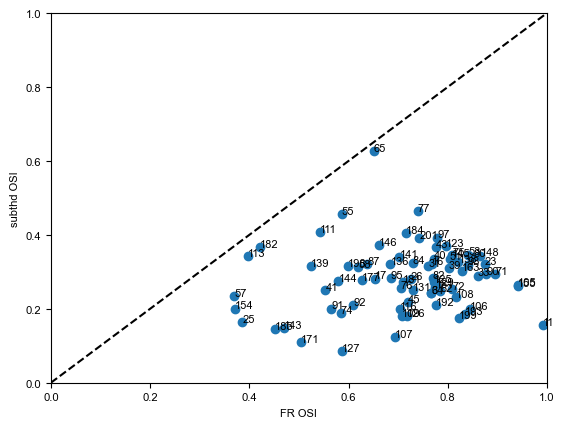

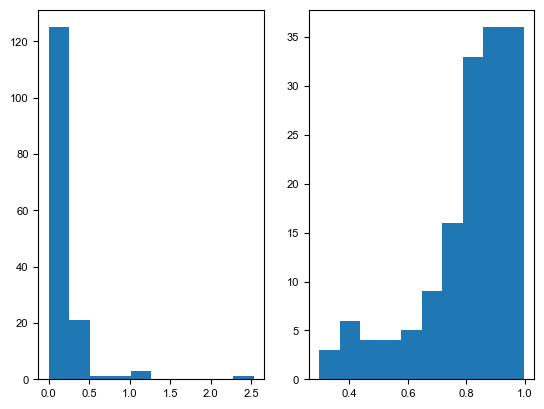

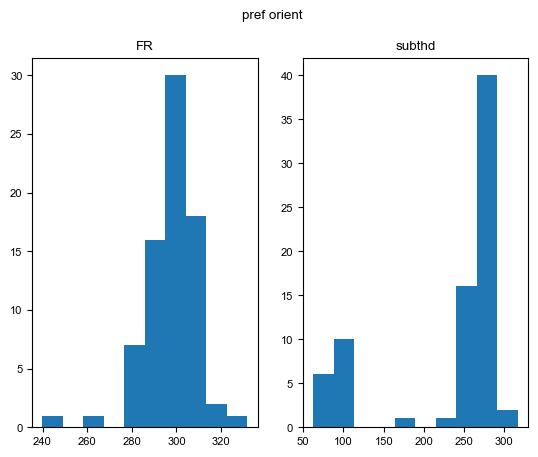

Time since last sync = 59.98 s


In [16]:
plot_os_OSI_group = os_double_guass_fit_OSI
plot_os_roi_idx = os_roi_idxs
plot_nof_rois, plot_nof_responses = plot_os_OSI_group.shape
plot_hist_titles = ["FR", "subthd"]

plt.figure()
for i_plot_reponse in range(plot_nof_responses):
    plt.subplot(1, plot_nof_responses, i_plot_reponse + 1)
    cur_OSIs = plot_os_OSI_group[:,i_plot_reponse]
    plt.hist(cur_OSIs, bins = np.linspace(0,1,11))
    cur_OSI_median = np.median(cur_OSIs)
    plt.axvline(cur_OSI_median, color = "black", linestyle = "--")
    plt.text(cur_OSI_median + 0.05, cur_OSIs.size/8, f"{cur_OSI_median:.2f}") 
    plt.title(plot_hist_titles[i_plot_reponse])
plt.suptitle("OSI")
plt.show()

plt.figure()
plt.scatter(plot_os_OSI_group[:,0], plot_os_OSI_group[:,1])
for i_roi in range(nof_rois):
    plt.text(plot_os_OSI_group[i_roi,0],
             plot_os_OSI_group[i_roi,1],
             f"{plot_os_roi_idx[i_roi]}")

plt.plot([0,1],[0,1], "k--")
plt.xlabel("FR OSI")
plt.ylabel("subthd OSI")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.hist(os_double_gauss_eva_Es.flatten())
plt.subplot(1,2,2)
plt.hist(os_double_gauss_eva_Rsquare.flatten())
plt.show()

plt.figure()
for i_plot_reponse in range(plot_nof_responses):
    plt.subplot(1, plot_nof_responses, i_plot_reponse + 1)
    cur_theta_prefs = os_double_gauss_theta_prefs[:,i_plot_reponse] * (180/np.pi)
    plt.hist(cur_theta_prefs, bins = 10)
    plt.title(plot_hist_titles[i_plot_reponse])
plt.suptitle("pref orient")
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [107]:
# select example fitting results
view_mask = np.full((os_roi_idxs.shape), True)
# view_mask = np.squeeze(np.abs(np.diff(os_double_gauss_theta_prefs, axis = -1))) < np.pi/8
# view_mask = np.squeeze(np.abs(np.diff(os_double_gauss_theta_prefs, axis = -1))) < np.pi/10
# view_mask = np.logical_and(view_mask, os_double_guass_fit_OSI[:,0] > 0.5)

print(np.where(view_mask))
print(os_roi_idxs[view_mask])

SAVE_PROGRESS(HISTORY_FILEPATH)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75], dtype=int64),)
[  3  11  16  17  23  25  26  31  33  39  40  41  43  45  51  53  55  57
  58  62  64  65  71  72  74  75  76  77  80  82  84  87  90  91  92  93
  95  97 105 106 107 108 109 111 113 116 123 125 126 127 129 131 136 138
 139 141 143 144 145 146 148 154 155 161 163 171 177 181 182 184 185 192
 193 198 199 201]
Time since last sync = 10.66 s


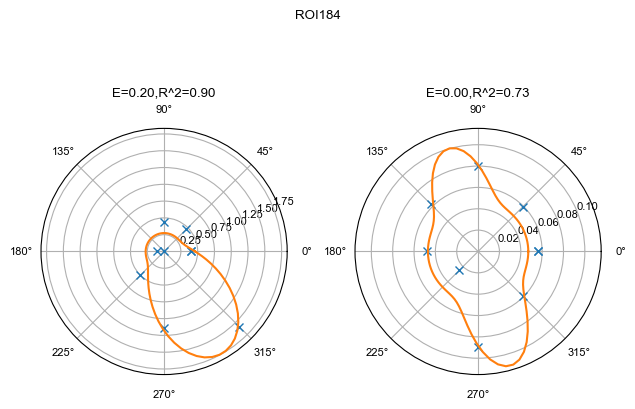

Time since last sync = 209.66 s


In [102]:
# example orientation tuning map polar plot

plot_cell_idx = 69

plot_os_roi_idxs = os_roi_idxs 
plot_os_orint_angle_rads  = os_orint_angle_rads 
plot_os_responses = os_responses 
plot_os_double_gauss_params = os_double_gauss_params 
plot_os_double_gauss_eva_Es = os_double_gauss_eva_Es 
plot_os_double_gauss_eva_Rsquare = os_double_gauss_eva_Rsquare 

plot_nof_responses = len(os_responses)
plot_nof_orints = os_responses[0].shape[-1]

plot_os_roi_idx = plot_os_roi_idxs[plot_cell_idx]

fit_plot_angle_rads = np.linspace(0, 2*np.pi, 100)

plt.figure()
for i_response in range(plot_nof_responses):
    cur_orint_angle_rads = plot_os_orint_angle_rads[i_response]
    cur_response = plot_os_responses[i_response][plot_os_roi_idx, :]
    cur_double_gauss_params = plot_os_double_gauss_params[plot_cell_idx, i_response, :]
    cur_double_gauss_obj = FitResponse.DoubleGaussian(cur_double_gauss_params)
    cur_fitted_responses = cur_double_gauss_obj.apply(fit_plot_angle_rads)
    
    plt.subplot(1, plot_nof_responses, i_response + 1, projection = 'polar')
    plot_ax = plt.gca()
    
    plt_polar_rs = cur_response
    plt_polar_thetas = cur_orint_angle_rads
    plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
    plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
    plt.polar(plt_polar_thetas, plt_polar_rs, 'x')

    plt_polar_rs = cur_fitted_responses
    plt_polar_thetas = fit_plot_angle_rads
    plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
    plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
    plt.polar(plt_polar_thetas, plt_polar_rs)

    plt.title(f"E={plot_os_double_gauss_eva_Es[plot_cell_idx, i_response]:.2f},R^2={plot_os_double_gauss_eva_Rsquare[plot_cell_idx, i_response]:.2f}")

plt.suptitle(f"ROI{os_roi_idxs[plot_cell_idx]}")
plt.tight_layout()
plt.show()
        
SAVE_PROGRESS(HISTORY_FILEPATH)

In [75]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    # There should be a method for this, but there isn't... Pull request?
    ax2._r_label_position._t = (22.5 + 180, 0.0)
    # ax2._r_label_position._t = (22.5 + 0, 0.0)
    ax2._r_label_position.invalidate()
    # Ensure that original axes tick labels are on top of plots in twinned axes
    for label in ax.get_yticklabels():
        ax.figure.texts.append(label)
    return ax2

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 119.42 s


In [76]:
dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

preview_subdir_name = "preview"
preview_subdir_path = os.path.join(dst_plot_subdir_path, preview_subdir_name)

if not os.path.isdir(preview_subdir_path):
    os.makedirs(preview_subdir_path)

print(preview_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)


J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures
J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\preview
Time since last sync = 120.68 s


In [ ]:
# make nice polar plot 

# plot_cell_idx = 22
# plot_cell_idx = 16
plot_cell_idx = 33
# plot_cell_idx = 1
# plot_cell_idx = 15
# plot_cell_idx = 20


plot_os_roi_idxs = os_roi_idxs 
plot_os_orint_angle_rads  = os_orint_angle_rads 
plot_os_responses = os_responses 
plot_os_double_gauss_params = os_double_gauss_params 
plot_os_double_gauss_eva_Es = os_double_gauss_eva_Es 
plot_os_double_gauss_eva_Rsquare = os_double_gauss_eva_Rsquare 

plot_nof_responses = len(os_responses)
plot_nof_orints = os_responses[0].shape[-1]

plot_colors = ["black", "#FF9B50"]
plot_y_labels = ["FR (Hz)", "dF/F (%)"]

plot_font_size = 6.5

plot_os_roi_idx = plot_os_roi_idxs[plot_cell_idx]
plot_nof_yticks = 3

plot_theta_ticks = np.arange(0,360,45)

fit_plot_angle_rads = np.linspace(0, 2*np.pi, 200)

plot_fig_width = letter_paper_size_inch[0] * (1/4)
plot_fig_height = letter_paper_size_inch[1] * (1/4)

dst_figure_name = f"double_gaussian_fit_roi{plot_os_roi_idx}"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fitted_responses = np.zeros((plot_nof_responses, len(fit_plot_angle_rads)))

plot_axs = []

plt.figure()
# plot_params = dict(projection='polar', theta_direction=-1, theta_offset=np.pi/2)
plot_params = dict(projection='polar')
fig, plot_ax = plt.subplots(figsize = (plot_fig_width, plot_fig_height), subplot_kw=plot_params)
# for i_response in range(plot_nof_responses):
for i_response in range(plot_nof_responses):
    cur_response_idx = plot_nof_responses - 1 -i_response
    cur_orint_angle_rads = plot_os_orint_angle_rads[cur_response_idx]
    cur_response = plot_os_responses[cur_response_idx][plot_os_roi_idx, :]
    cur_double_gauss_params = plot_os_double_gauss_params[plot_cell_idx, cur_response_idx, :]
    cur_double_gauss_obj = FitResponse.DoubleGaussian(cur_double_gauss_params)
    cur_fitted_responses = cur_double_gauss_obj.apply(fit_plot_angle_rads)
    fitted_responses[cur_response_idx, :] = cur_fitted_responses
    
    # plt.subplot(1, plot_nof_responses, i_response + 1, projection = 'polar')
    if i_response == 0:
        # plot_ax = plt.gca()
        pass
    elif i_response == 1:
        plot_ax = polar_twin(plot_ax)
        # plot_ax.set_frame_on(False)
        plot_ax.grid(False)

    plot_axs.append(plot_ax)
    
    plt_polar_rs = cur_response
    plt_polar_thetas = cur_orint_angle_rads
    plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
    plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
    plot_ax.scatter(plt_polar_thetas, 
                    plt_polar_rs, 
                    color = plot_colors[cur_response_idx],
                    zorder = 10,
                   )

    plt_polar_rs = cur_fitted_responses
    plt_polar_thetas = fit_plot_angle_rads
    plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
    plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
    plot_ax.plot(plt_polar_thetas, 
                 plt_polar_rs,
                 color = plot_colors[cur_response_idx],
                 zorder = 10,
                )

    cur_max_r = np.max(cur_fitted_responses)
    
    cur_y_ticks = None
    cur_y_tick_labels = None
    if cur_response_idx == 0:
        plot_ax.set_rlabel_position(+22.5)
        cur_y_lim = [0, 1.5 * cur_max_r]
        cur_y_ticks = np.linspace(cur_y_lim[0], cur_y_lim[1], plot_nof_yticks)
        cur_y_ticks = cur_y_ticks[1:]
        cur_y_tick_labels = [f"{tick:.2f}" for tick in cur_y_ticks]
    elif cur_response_idx == 1:
        plot_ax.set_rlabel_position(45 + 22.5)
        cur_y_lim = [0, 1.05 * cur_max_r]
        cur_y_ticks = np.linspace(cur_y_lim[0], cur_y_lim[1], plot_nof_yticks)
        cur_y_ticks = cur_y_ticks[1:]
        cur_y_tick_labels = [f"{-tick*1E2:.2f}" for tick in cur_y_ticks]
    plt.ylim(cur_y_lim)
    plot_ax.set_yticks(ticks = cur_y_ticks, 
                        labels = cur_y_tick_labels,
                        color = plot_colors[cur_response_idx])

    plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = -5)
    plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size, pad = 0) 
    plot_ax.set_thetagrids(plot_theta_ticks)
    
    cur_label_position=plot_ax.get_rlabel_position()
    # plot_ax.text(np.radians(cur_label_position),plot_ax.get_rmax()*0.75,
    #              plot_y_labels[cur_response_idx],
    #              # rotation=cur_label_position,
    #              # ha='center',
    #              # va='center',
    #              ha='center',
    #              va='bottom',
    #              color =  plot_colors[cur_response_idx],
    #             )
    

# plot_axs[0].set_zorder(plot_axs[1].get_zorder() + 1)
# plot_axs[0].patch.set_visible(False)
# plot_axs[1].patch.set_visible(False)


# plt.suptitle(f"ROI{os_roi_idxs[plot_cell_idx]}")
# plt.tight_layout()

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_cell_idx", data = plot_cell_idx)
    hdf5_file.create_dataset("plot_os_roi_idx", data = plot_os_roi_idx)
    hdf5_file.create_dataset("plot_os_roi_idxs", data = plot_os_roi_idxs )
    hdf5_file.create_dataset("plot_os_responses", data = plot_os_responses)
    hdf5_file.create_dataset("plot_os_double_gauss_params", data = plot_os_double_gauss_params)
    hdf5_file.create_dataset("plot_os_double_gauss_eva_Es", data = plot_os_double_gauss_eva_Es)
    hdf5_file.create_dataset("plot_os_double_gauss_eva_Rsquare", data = plot_os_double_gauss_eva_Rsquare)
    hdf5_file.create_dataset("plot_y_labels", data = plot_y_labels)
    hdf5_file.create_dataset("fit_plot_angle_rads", data = fit_plot_angle_rads)
    hdf5_file.create_dataset("fitted_responses", data = fitted_responses)
    hdf5_file.create_dataset("plot_theta_ticks", data = plot_theta_ticks)
    hdf5_file.create_dataset("plot_os_orint_angle_rads", data = plot_os_orint_angle_rads)
    hdf5_file.create_dataset("plot_nof_yticks", data = plot_nof_yticks)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\double_gaussian_fit_roi184_ver01.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\double_gaussian_fit_roi184_ver01.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\double_gaussian_fit_roi184_ver01.hdf5


<Figure size 640x480 with 0 Axes>

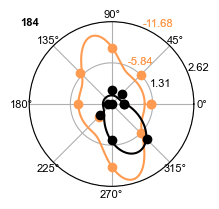

Time since last sync = 227.73 s


In [103]:
# make nice polar plot 

# plot_cell_idx = 15
# plot_cell_idx = 19
# plot_cell_idx = 38
# plot_cell_idx = 43
# plot_cell_idx = 62
plot_cell_idx = 69

plot_os_roi_idxs = os_roi_idxs 
plot_os_orint_angle_rads  = os_orint_angle_rads 
plot_os_responses = os_responses 
plot_os_double_gauss_params = os_double_gauss_params 
plot_os_double_gauss_eva_Es = os_double_gauss_eva_Es 
plot_os_double_gauss_eva_Rsquare = os_double_gauss_eva_Rsquare 

plot_nof_responses = len(os_responses)
plot_nof_orints = os_responses[0].shape[-1]

plot_colors = ["black", "#FF9B50"]
plot_y_labels = ["FR (Hz)", "dF/F (%)"]

# plot_font_size = 6.5
plot_font_size = 8

plot_os_roi_idx = plot_os_roi_idxs[plot_cell_idx]
plot_nof_yticks = 3

plot_theta_ticks = np.arange(0,360,45)

fit_plot_angle_rads = np.linspace(0, 2*np.pi, 200)

plot_fig_width = letter_paper_size_inch[0] * (1/4)
plot_fig_height = letter_paper_size_inch[1] * (1/4)

dst_figure_name = f"double_gaussian_fit_roi{plot_os_roi_idx}_ver01"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fitted_responses = np.zeros((plot_nof_responses, len(fit_plot_angle_rads)))

plot_axs = []

plt.figure()
# plot_params = dict(projection='polar', theta_direction=-1, theta_offset=np.pi/2)
plot_params = dict(projection='polar')
fig, plot_ax = plt.subplots(figsize = (plot_fig_width, plot_fig_height), subplot_kw=plot_params)
# for i_response in range(plot_nof_responses):
for i_response in range(plot_nof_responses):
    cur_response_idx = plot_nof_responses - 1 -i_response
    cur_orint_angle_rads = plot_os_orint_angle_rads[cur_response_idx]
    cur_response = plot_os_responses[cur_response_idx][plot_os_roi_idx, :]
    cur_double_gauss_params = plot_os_double_gauss_params[plot_cell_idx, cur_response_idx, :]
    cur_double_gauss_obj = FitResponse.DoubleGaussian(cur_double_gauss_params)
    cur_fitted_responses = cur_double_gauss_obj.apply(fit_plot_angle_rads)
    fitted_responses[cur_response_idx, :] = cur_fitted_responses
    
    # plt.subplot(1, plot_nof_responses, i_response + 1, projection = 'polar')
    if i_response == 0:
        # plot_ax = plt.gca()
        pass
    elif i_response == 1:
        plot_ax = polar_twin(plot_ax)
        # plot_ax.set_frame_on(False)
        plot_ax.grid(False)

    plot_axs.append(plot_ax)
    
    plt_polar_rs = cur_response
    plt_polar_thetas = cur_orint_angle_rads
    plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
    plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
    plot_ax.scatter(plt_polar_thetas, 
                    plt_polar_rs, 
                    color = plot_colors[cur_response_idx],
                    zorder = 10,
                   )

    plt_polar_rs = cur_fitted_responses
    plt_polar_thetas = fit_plot_angle_rads
    plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
    plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
    plot_ax.plot(plt_polar_thetas, 
                 plt_polar_rs,
                 color = plot_colors[cur_response_idx],
                 zorder = 10,
                )

    cur_max_r = np.max(cur_fitted_responses)
    
    cur_y_ticks = None
    cur_y_tick_labels = None
    if cur_response_idx == 0:
        plot_ax.set_rlabel_position(+22.5)
        cur_y_lim = [0, 1.5 * cur_max_r]
        cur_y_ticks = np.linspace(cur_y_lim[0], cur_y_lim[1], plot_nof_yticks)
        cur_y_ticks = cur_y_ticks[1:]
        cur_y_tick_labels = [f"{tick:.2f}" for tick in cur_y_ticks]
    elif cur_response_idx == 1:
        plot_ax.set_rlabel_position(45 + 22.5)
        cur_y_lim = [0, 1.05 * cur_max_r]
        cur_y_ticks = np.linspace(cur_y_lim[0], cur_y_lim[1], plot_nof_yticks)
        cur_y_ticks = cur_y_ticks[1:]
        cur_y_tick_labels = [f"{-tick*1E2:.2f}" for tick in cur_y_ticks]
    plt.ylim(cur_y_lim)
    plot_ax.set_yticks(ticks = cur_y_ticks, 
                        labels = cur_y_tick_labels,
                        color = plot_colors[cur_response_idx])

    plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = -5)
    plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size, pad = 0) 
    plot_ax.set_thetagrids(plot_theta_ticks)
    
    cur_label_position=plot_ax.get_rlabel_position()
    # plot_ax.text(np.radians(cur_label_position),plot_ax.get_rmax()*0.75,
    #              plot_y_labels[cur_response_idx],
    #              # rotation=cur_label_position,
    #              # ha='center',
    #              # va='center',
    #              ha='center',
    #              va='bottom',
    #              color =  plot_colors[cur_response_idx],
    #             )

    # add roi number
plot_ax = plot_ax.figure.add_axes(plot_ax.get_position())
plot_ax.text(0,
             1,
             f"{plot_os_roi_idx}",
             fontsize = plot_font_size,
             fontname = "Arial",
             verticalalignment = "center",
             horizontalalignment = "center",
             fontweight = "bold",
            )
plot_ax.axis("off")

# plot_axs[0].set_zorder(plot_axs[1].get_zorder() + 1)
# plot_axs[0].patch.set_visible(False)
# plot_axs[1].patch.set_visible(False)


# plt.suptitle(f"ROI{os_roi_idxs[plot_cell_idx]}")
# plt.tight_layout()

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_cell_idx", data = plot_cell_idx)
    hdf5_file.create_dataset("plot_os_roi_idx", data = plot_os_roi_idx)
    hdf5_file.create_dataset("plot_os_roi_idxs", data = plot_os_roi_idxs )
    hdf5_file.create_dataset("plot_os_responses", data = plot_os_responses)
    hdf5_file.create_dataset("plot_os_double_gauss_params", data = plot_os_double_gauss_params)
    hdf5_file.create_dataset("plot_os_double_gauss_eva_Es", data = plot_os_double_gauss_eva_Es)
    hdf5_file.create_dataset("plot_os_double_gauss_eva_Rsquare", data = plot_os_double_gauss_eva_Rsquare)
    hdf5_file.create_dataset("plot_y_labels", data = plot_y_labels)
    hdf5_file.create_dataset("fit_plot_angle_rads", data = fit_plot_angle_rads)
    hdf5_file.create_dataset("fitted_responses", data = fitted_responses)
    hdf5_file.create_dataset("plot_theta_ticks", data = plot_theta_ticks)
    hdf5_file.create_dataset("plot_os_orint_angle_rads", data = plot_os_orint_angle_rads)
    hdf5_file.create_dataset("plot_nof_yticks", data = plot_nof_yticks)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\osi_hist_comparison.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\osi_hist_comparison.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\osi_hist_comparison.hdf5


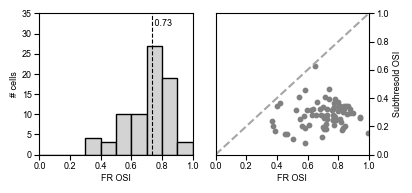

Time since last sync = 107.79 s


In [108]:
# nice OSI hist plot

plot_os_OSI_group = os_double_guass_fit_OSI
plot_os_roi_idx = os_roi_idxs
plot_nof_rois, plot_nof_responses = plot_os_OSI_group.shape
# plot_hist_titles = ["FR", "subthd"]

plot_show_hist_idx = 0
plot_hist_vals = plot_os_OSI_group[:, plot_show_hist_idx]
plot_hist_median = np.median(plot_hist_vals)
plot_hist_y_ticks = np.arange(0,40,5)

plot_font_size = 6.5

plot_hist_color = r"#d3d3d3"
plot_hist_edge_color = r"black"
plot_scatter_color =  r"#808080"
plot_scatter_size = 10
plot_line_color = r"#a6a6a6"

dst_figure_name = f"osi_hist_comparison"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

fig_width = letter_paper_size_inch[0] * (16/32)
fig_height = letter_paper_size_inch[1] * (3/18)

fig = plt.figure(figsize = (fig_width, fig_height))

gs = mpl_gridspec.GridSpec(1, 2, figure = fig)
gs.update(wspace=0.15, hspace=0.0)

plt.subplot(gs[0,0])
plot_ax = plt.gca()
plt.hist(plot_hist_vals, 
         bins = np.linspace(0,1,11),
         color = plot_hist_color, 
         edgecolor = plot_hist_edge_color,
         # linewidth = 0.8,
         linewidth = 1,
        )
plt.axvline(plot_hist_median, 
            color = plot_hist_edge_color, 
            linestyle = "--",
            linewidth = 0.8)
plt.text(
         x = plot_hist_median + 0.0,
         y = 32,
         s = f" {plot_hist_median:0.2f}",
         horizontalalignment='left',
         color = "black",
         fontsize = plot_font_size, 
         fontname = "Arial",
         # fontweight = "bold",
        )
plt.yticks(plot_hist_y_ticks, plot_hist_y_ticks)
plt.ylim([plot_hist_y_ticks[0], plot_hist_y_ticks[-1]])
plt.xlim([0, 1])

plt.xlabel("FR OSI",
           fontsize = plot_font_size, fontname = "Arial", labelpad = 2)
plt.ylabel("# cells", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 2)
plot_ax.tick_params(axis='both', which='major', 
                    labelsize=plot_font_size, pad = 2)
plot_ax.tick_params(axis='both', which='minor', 
                    labelsize=plot_font_size)

plt.subplot(gs[0,1])
plot_ax = plt.gca()
plt.scatter(plot_os_OSI_group[:,0], 
            plot_os_OSI_group[:,1],
            c = plot_scatter_color,
            s = plot_scatter_size)
plt.plot([0,1],[0,1], 
         linestyle = "--", 
         color = plot_line_color)
plt.xlabel("FR OSI",
          fontsize = plot_font_size, fontname = "Arial", labelpad = 2)
plt.ylabel("Subthresold OSI",
          fontsize = plot_font_size, fontname = "Arial", labelpad = 3)
plot_ax.yaxis.set_label_position("right")
plot_ax.yaxis.tick_right()
plt.xlim([0, 1])
plt.ylim([0, 1])
plot_ax.tick_params(axis='both', which='major', 
                    labelsize=plot_font_size, pad = 2)
plot_ax.tick_params(axis='both', which='minor', 
                    labelsize=plot_font_size)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_os_OSI_group", data = np.array(plot_os_OSI_group))
    hdf5_file.create_dataset("plot_os_roi_idx", data = plot_os_roi_idx)
    hdf5_file.create_dataset("plot_show_hist_idx", data = plot_show_hist_idx)
    hdf5_file.create_dataset("plot_hist_vals", data = plot_hist_vals)
    hdf5_file.create_dataset("plot_hist_median", data = plot_hist_median)
    hdf5_file.create_dataset("plot_hist_y_ticks", data = plot_hist_y_ticks)


%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)